In [75]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import glob 
import warnings
warnings.filterwarnings('ignore')

In [51]:
global height
global width
height = 384
width = 384

In [3]:
CLASSES = {'wagon': 3, 'rail': 5}

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
files_path = os.path.join('/home/dnikitin/Downloads/train_3_classes_dataset/*/img', '*.png')
masks_path = os.path.join('/home/dnikitin/Downloads/train_3_classes_dataset/*/masks_machine', '*.png')
    # Load training images
files_paths = sorted(glob.glob(files_path))
masks_paths = sorted(glob.glob(masks_path))

In [6]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples, train_masks, validation_masks = train_test_split(files_paths, masks_paths, test_size=0.2,random_state=17)

In [64]:
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image,(width,height),interpolation = cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask,(width,height),interpolation = cv2.INTER_NEAREST)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in list(CLASSES.values())]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [8]:
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [9]:
# Lets look at data we have
dataset = Dataset(train_samples, train_masks)

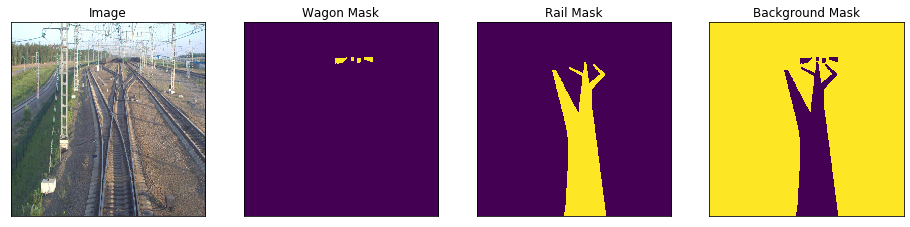

In [10]:
image, mask = dataset[110] # get some sample
visualize(
    image=image, 
    wagon_mask=mask[..., 0].squeeze(),
    rail_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

In [11]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [12]:
BACKBONE = 'resnet34'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 40
n_classes = 3

In [ ]:
model = sm.FPN(BACKBONE, classes=n_classes, activation = 'softmax')

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (wagon: 2.; rail: 1.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([2, 1, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [15]:
# Dataset for train images
train_dataset = Dataset(
    train_samples, 
    train_masks
)

# Dataset for validation images
valid_dataset = Dataset(
    validation_samples, 
    validation_masks
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=False, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [16]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

W0911 18:18:06.703533 139991968577344 deprecation.py:323] From /home/dnikitin/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
124/124 [==============================] - 67s 542ms/step - loss: 0.2103 - iou_score: 0.7984 - f1-score: 0.8734 - val_loss: 0.1250 - val_iou_score: 0.8347 - val_f1-score: 0.8840
Epoch 2/40
124/124 [==============================] - 58s 468ms/step - loss: -0.0497 - iou_score: 0.9176 - f1-score: 0.9556 - val_loss: 0.0201 - val_iou_score: 0.8875 - val_f1-score: 0.9278
Epoch 3/40
124/124 [==============================] - 59s 472ms/step - loss: -0.0864 - iou_score: 0.9415 - f1-score: 0.9691 - val_loss: -0.0033 - val_iou_score: 0.8947 - val_f1-score: 0.9353
Epoch 4/40
124/124 [==============================] - 58s 468ms/step - loss: -0.1025 - iou_score: 0.9521 - f1-score: 0.9749 - val_loss: -0.0259 - val_iou_score: 0.9125 - val_f1-score: 0.9461
Epoch 5/40
124/124 [==============================] - 59s 473ms/step - loss: -0.1116 - iou_score: 0.9584 - f1-score: 0.9783 - val_loss: -0.0375 - val_iou_score: 0.9194 - val_f1-score: 0.9510
Epoch 6/40
124/124 [============================

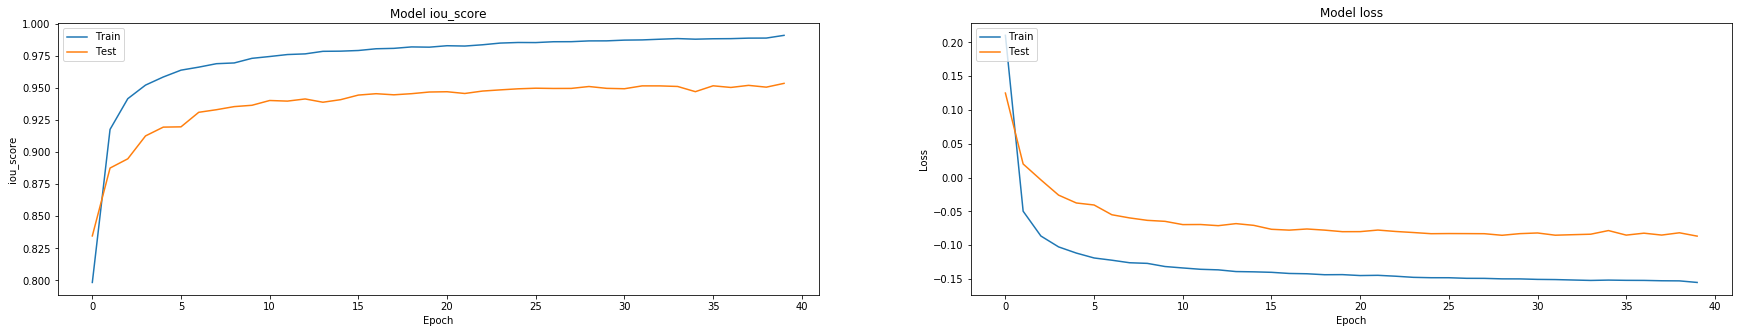

In [17]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [65]:
x_test_dir = os.path.join('/home/dnikitin/Downloads/test_3_classes_dataset/*/img', '*.png')
y_test_dir = os.path.join('/home/dnikitin/Downloads/test_3_classes_dataset/*/masks_machine', '*.png')
x_test_paths = sorted(glob.glob(x_test_dir))
y_test_paths = sorted(glob.glob(y_test_dir))

In [66]:
test_dataset = Dataset(
    x_test_paths, 
    y_test_paths
)

In [67]:
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=True)

In [69]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.043313
mean iou_score: 0.84783
mean f1-score: 0.90428


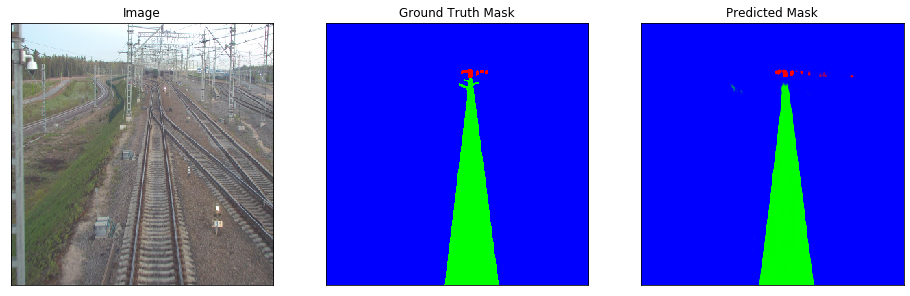

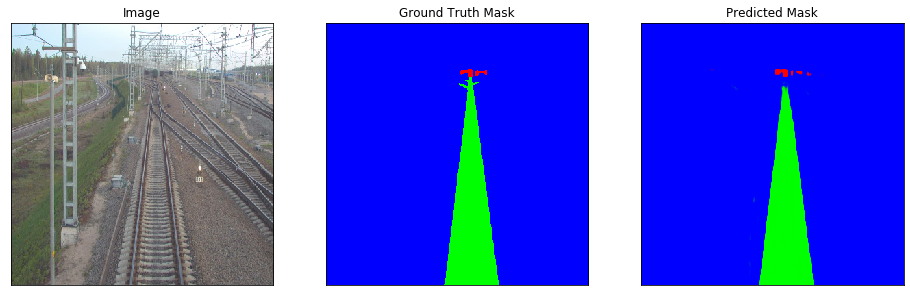

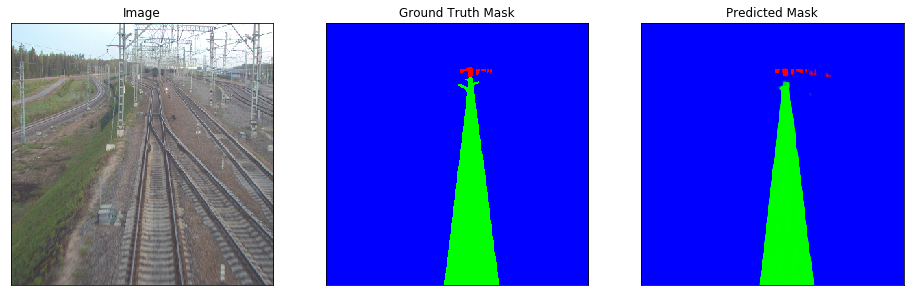

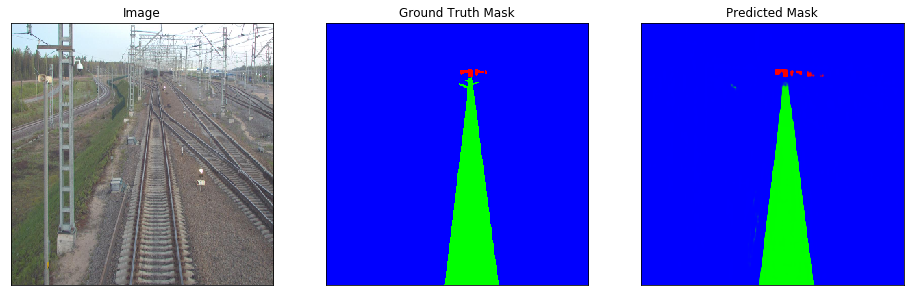

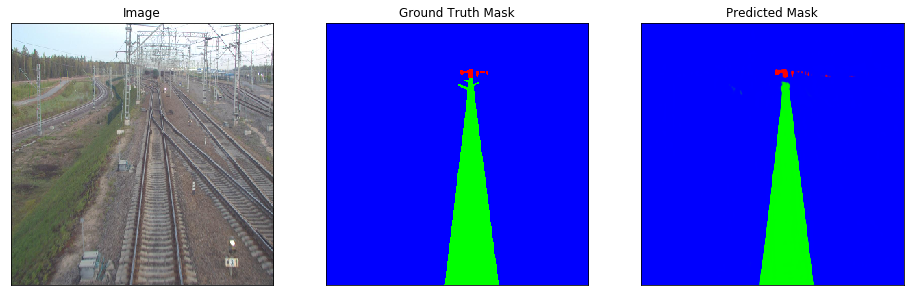

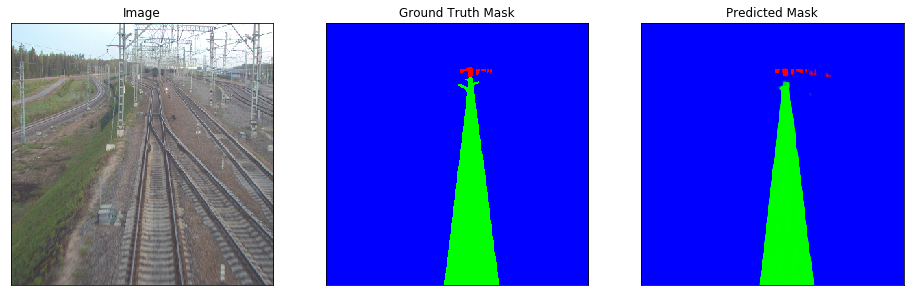

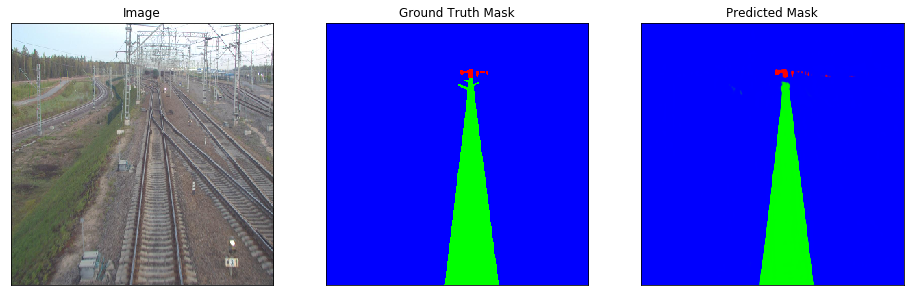

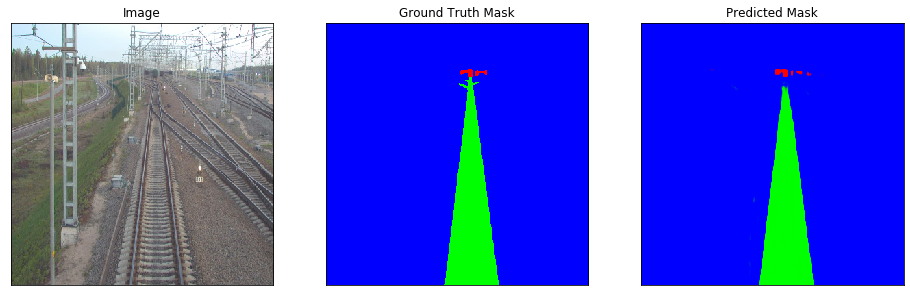

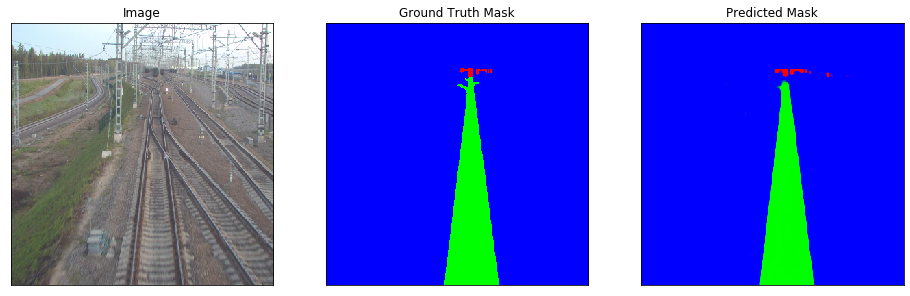

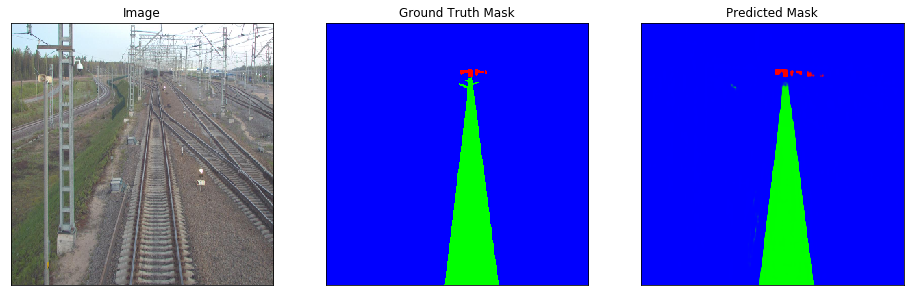

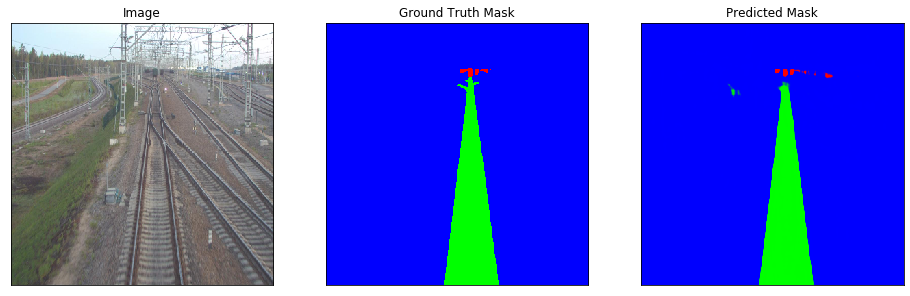

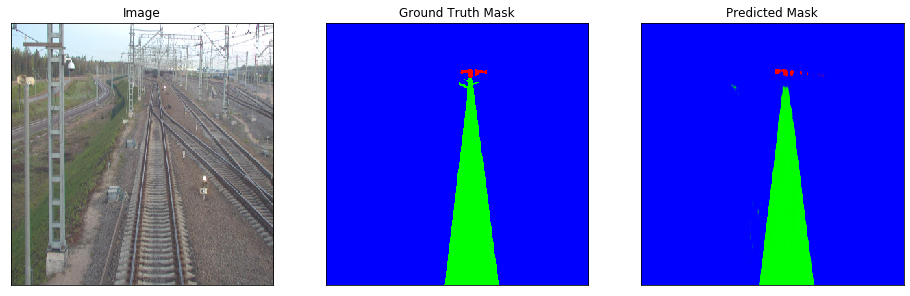

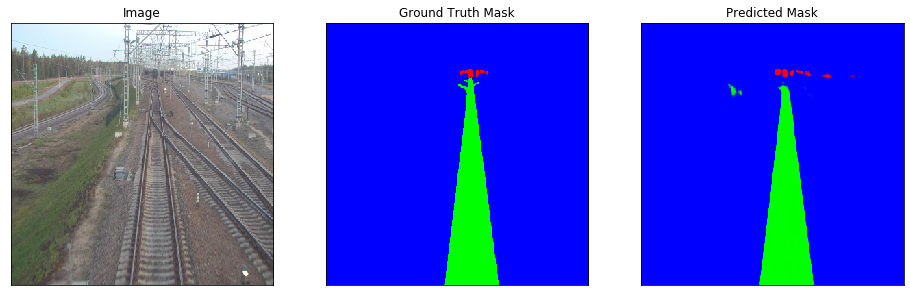

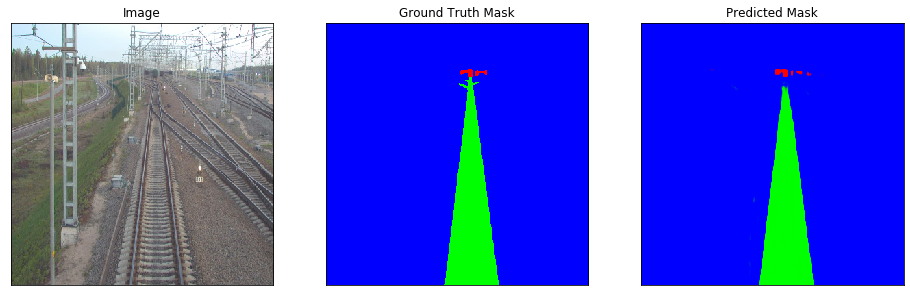

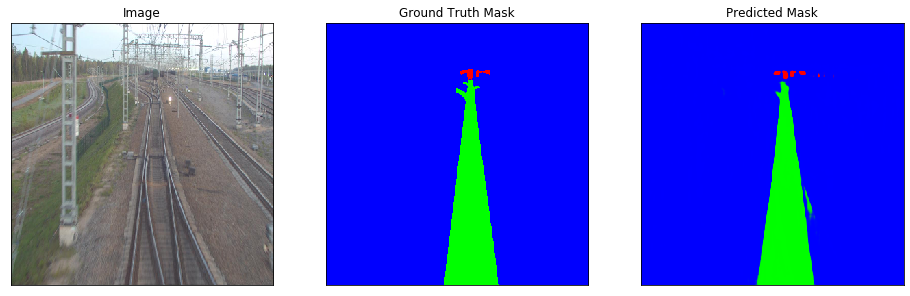

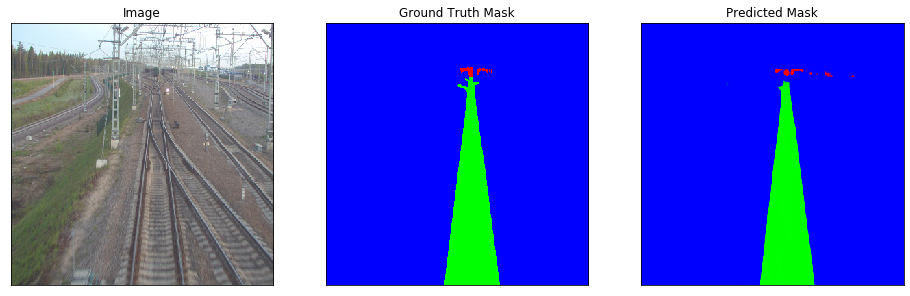

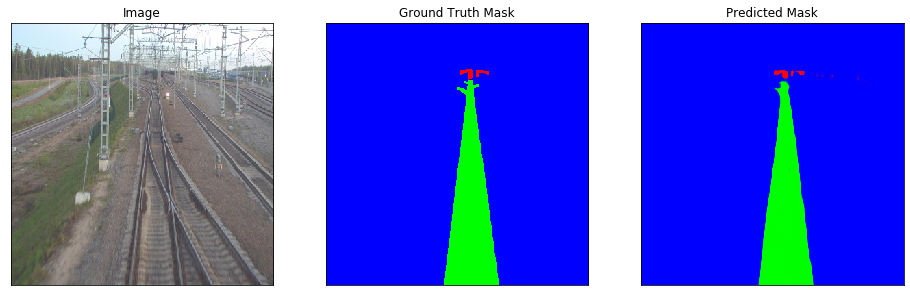

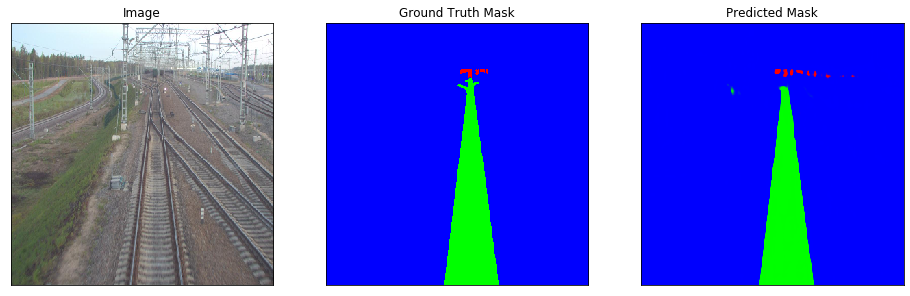

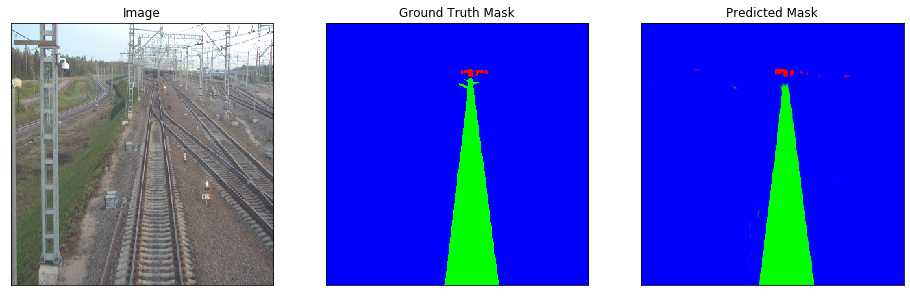

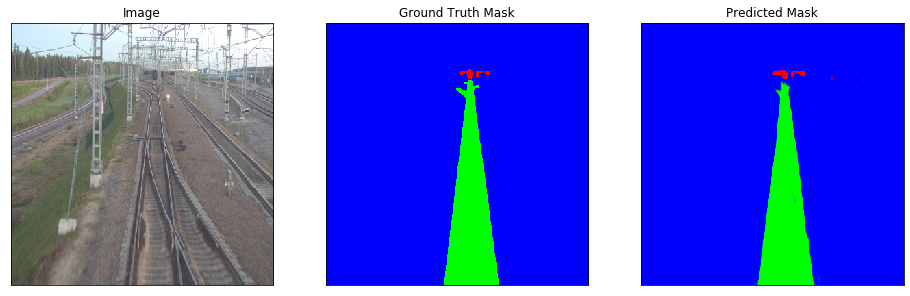

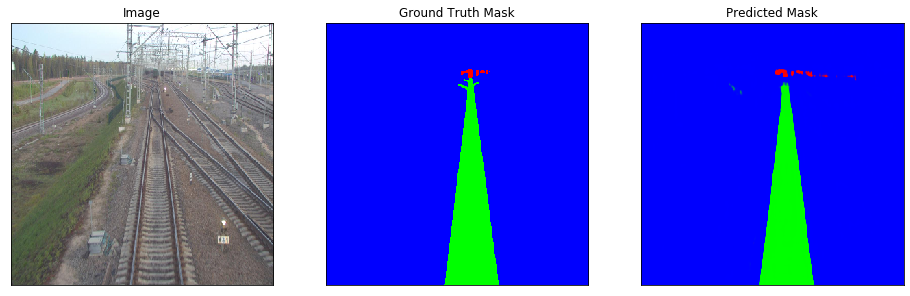

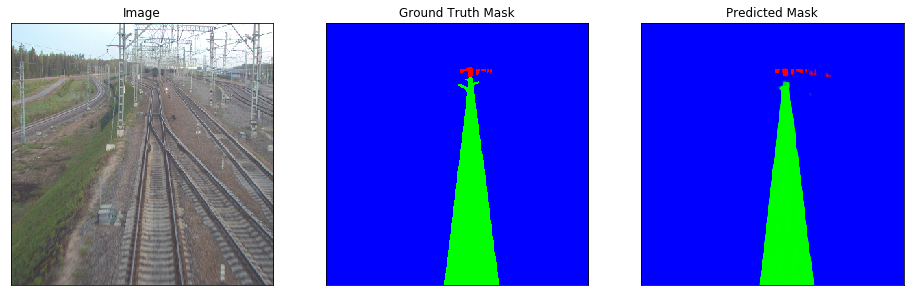

In [73]:
n = 22
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=image.squeeze(),
        ground_truth_mask=gt_mask.squeeze(),
        predicted_mask=pr_mask.squeeze(),
    )